# Wine market study


## Wine market study

The client, Domaine des Croix, is looking to define the price of its wine bottles for the US market. They have retrieved a set of 130k bottles of wine, with grape varieties, countries and regions of production, vintages (i.e. years of production), as well as notes ('points') and descriptions from oenologists (wine specialists), and the price of all these bottles on the American market.

**The objective will be to make a presentation of the market analysis and the price you recommend for the client's wines.** The client is not a data analyst, but would like to understand the process. You will have to explain how the prices were set, without getting too technical, in other words: make it easy to understand.

## Data sets
- Dataset of 130k wines: https://github.com/murpi/wilddata/raw/master/wine.zip
- Dataset of the 14 Domaine des Croix wines: https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv


## Expected deliverables
The client would like an 5 minutes presentation followed by 5 minutes of questions. 
The presentation will contain at least these elements:
- Reminder of the context and the problem
- Exploratory analysis of the data
- Methodology, tools and languages used
- Presentation of the technical part and the code created for this analysis
- Answer to the business question: price proposal or price range to the client to be correctly positioned against the competition on the American market

# Data preparation and exploratory analysis





## Preprocessing
The 'title' column contains the domain, the vintage and the variety. You must isolate the vintage (year) in a dedicated column.

## Market analysis

## Proposed KPI
- By country:
  - Distribution of number of wines per country (grouping countries by quartile according to the number of wines produced)
  - Top producer countries ranked by score
- By variety:
  - Average score, **price and number** of wines produced by grape variety
  - Top ranked grape varieties
  - Most produced varieties
  - Most expensive varieties

- Time series:
  - Number of wines produced by year (top 10 most produced grape varieties)

- Pinot Noir variety:
  - Pinot Noir titles by price
  - Countries producing the most Pinot noir titles
  - Main Pinot Noir wineries
  - Number of Pinot Noir titles produced by year and country

- Note:
  - the distribution by decile was incorporated in the pertinent KPI 


## Descriptions
What words stand out the most in the wine descriptions? And specifically for Pinot Noir, is it very different?  What about the Burgundi province in France?


## Preprocessing

### Libraries imports, installs and settings

In [ ]:
# Installs
%pip install geopandas
%pip install folium  
%pip install plotly==5.11.0
%pip install plotly.express
%pip install pycountry
%pip install squarify


In [ ]:
# Settings
# pd.options.display.max_colwidth = 100

In [ ]:
# Imports
import pandas as pd
import numpy as np
import math   
import matplotlib.pyplot as plt

import seaborn as sns
import squarify 
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.graph_objects as go
import plotly.io as pio

import pycountry

import re

import datetime

import nltk
import spacy
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [ ]:
# Downloads
nltk.download('popular')
nltk.download('punkt')

In [ ]:
# Export data sets

# Cats
## Original ds (processed)
# df_domaine.to_csv("df_domaine.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)

## Distribution of number of wines per country
# df_global_calc.to_csv("df_global_calc.csv", index=False)
# df_producers_outliers_lower.to_csv("df_producers_outliers_lower.csv", index=False)
# df_producers_outliers_upper.to_csv("df_producers_outliers_upper.csv", index=False)
# df_producers_q0_q1.to_csv("df_producers_q0_q1.csv", index=False)
# df_producers_q1_q2.to_csv("df_producers_q1_q2.csv", index=False)
# df_producers_q2_q3.to_csv("df_producers_q2_q3.csv", index=False)
# df_producers_q3_q4.to_csv("df_producers_q3_q4.csv", index=False)

# df_producers_q3_to_max.to_csv("df_producers_q3_to_max.csv", index=False)

## Top producer countries ranked by score (proposed) = VIZ Countries with the best sores
# df_best_scores.to_csv("df_best_scores.csv", index=False)

# Average score and price by grape variety, top 10 producers
df_grape_variety_10.to_csv("df_grape_variety_10.csv", index=False)

# df_global.to_csv("df_global.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)

### Datasets imports

In [ ]:
# Datasets
link_global = 'https://github.com/murpi/wilddata/raw/master/wine.zip' # Dataset of 130k wines
link_domaine = 'https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv' # Dataset of the 14 Domaine des Croix wines

df_global_raw = pd.read_csv(link_global)
df_domaine_raw = pd.read_csv(link_domaine)

In [ ]:
# Fast reset of df, even with my slow internet connection
df_global = df_global_raw.copy()
df_domaine = df_domaine_raw.copy()

### Reusable functions

In [ ]:
# Check for percentage of missing values
def missing_values(my_df):
  percent_missing = my_df.isnull().sum() * 100 / len(my_df)
  percent_missing_df = pd.DataFrame({'column': percent_missing.index, 'percent_missing': percent_missing.values})
  return percent_missing_df

In [ ]:
# Drops null rows from df_global when the column of interest has less than 7% of null values

# Example col focus:
# cols_focus = ['country', 'points', 'price', 'year'] 

def drop_null_rows(my_df, cols_focus):
    null_counts = my_df[cols_focus].isnull().sum()
    null_threshold = my_df.shape[0] * 0.07
    columns_to_drop = null_counts[null_counts < null_threshold].index
    my_df = my_df.dropna(subset=columns_to_drop, axis=0)
    return my_df

In [ ]:
# Define function that takes a dataframe, a column name, and a mathematical operation as arguments
# and returns the dataframe with an additional column:
def add_col(my_df, col_group, col_agg_1, col_agg_2, aggregation_1, aggregation_2):
  new_col_1 = col_agg_1 + '_' + aggregation_1
  new_col_2 = col_agg_2 + '_' + aggregation_2

  df_extended = (my_df.groupby(col_group)[[col_agg_1, col_agg_2]].agg({col_agg_1:aggregation_1, col_agg_2:aggregation_2 })
                            .reset_index()
                            .rename(columns={col_agg_1: new_col_1, col_agg_2: new_col_2})
                            )
  return df_extended

# Example:
result = add_col(df_global, 'country','points', 'variety', 'mean', 'count').sort_values(by=['variety_count'], ascending=False)

display(result.head(3))

,country,points_mean,variety_count
40,US,88.563720,54504
15,France,88.842520,22079
22,Italy,88.562231,19540


In [ ]:
def add_col_extra(my_df, col_group, col_agg_1, col_agg_2, col_agg_3, aggregation_1, aggregation_2, aggregation_3):
  new_col_1 = col_agg_1 + '_' + aggregation_1
  new_col_2 = col_agg_2 + '_' + aggregation_2
  new_col_3 = col_agg_3 + '_' + aggregation_3

  df_extended = (my_df.groupby(col_group)[[col_agg_1, col_agg_2, col_agg_3]].agg({col_agg_1:aggregation_1, col_agg_2:aggregation_2, col_agg_3:aggregation_3})
                            .reset_index()
                            .rename(columns={col_agg_1: new_col_1, col_agg_2: new_col_2, col_agg_3: new_col_3})
                            )
  return df_extended

# Example:
result = add_col_extra(df_global, 'country','points', 'price', 'variety','mean', 'mean', 'count').sort_values(by=['variety_count'], ascending=False)

display(result.head(3))

,country,points_mean,price_mean,variety_count
40,US,88.563720,36.166295,54504
15,France,88.842520,41.524233,22079
22,Italy,88.562231,41.759607,19540


In [ ]:
# import nltk
# import string
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
punctuations = list(string.punctuation)

def analize_descriptions(my_df, my_col, n):
  # concatenate all descriptions into a single string
  all_descriptions = " ".join(my_df[my_col].tolist())

  # remove punctuations
  words = [word for word in word_tokenize(all_descriptions) if word.lower() not in punctuations]

  # remove stop words
  filtered_words = [word for word in words if word.lower() not in stop_words]

  # count the frequency of each word in the list
  word_frequency = {}
  for word in filtered_words:
      if word in word_frequency:
          word_frequency[word] += 1
      else:
          word_frequency[word] = 1

  # sort the word frequency count in descending order
  sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

  # the most frequent words will be the first items in the sorted list
  most_frequent_words = sorted_word_frequency[:n] # where n is the number of words you want to retrieve
  return most_frequent_words


### Datasets prepping

#### df_domaine

In [ ]:
# Creation of col year
def extract_years_1(string):
    years = re.findall(r'\b\d{4}\b', string)
    if years:
        years = [int(year) for year in years]
        return int(years[0])
    return np.nan

# Apply the function to each element in the 'title' column
df_domaine['year'] = df_domaine['title'].apply(extract_years_1)

In [ ]:
# Decide on time span of analysis
max_year_domain = df_domaine['year'].max()
min_year_domain = df_domaine['year'].min()
print("Max year domain = ", max_year_domain)
print("Min year domain = ", min_year_domain)

max_year = max_year_domain
min_year = min_year_domain
print("Max year = ", max_year)
print("Min year = ", min_year)

Max year domain =  2019
Min year domain =  2014
Max year =  2019
Min year =  2014


#### df_global

In [ ]:
# Creation of col year, to be made in several steps
# Function to extract all years (4-digit format)
def extract_years(string):
    years = re.findall(r'\b\d{4}\b', string)
    if years:
        years = [int(year) for year in years]
        return years
    return np.nan

# Apply the function to each element in the 'title' column
df_global['year'] = df_global['title'].apply(extract_years)

In [ ]:
# Calculate missing values
missing_values_global = missing_values(df_global)
missing_values_domaine = missing_values(df_domaine)

print('Missing values global')
display(missing_values_global)

Missing values global


,column,percent_missing
0,country,0.048478
1,description,0.000000
2,designation,28.824919
3,points,0.000000
4,price,6.919981
5,province,0.048478
6,region_1,16.349254
7,region_2,61.132528
8,taster_name,20.194372
9,taster_twitter_handle,24.017944


In [ ]:
# Drops null rows from df_global when the column of interest has less than 7% of null values
cols_focus = ['country', 'points', 'price', 'year'] 

df_global = drop_null_rows(df_global, cols_focus)

In [ ]:
# extract values between min_year and max_yesr 

# # To do: fix this ugly harcoded years
# # Following code sends error: TypeError: '<=' not supported between instances of 'int' and 'str'
# df_global['year'] = df_global['year'].apply(lambda x: [y for y in x if min_year <= y <= max_year])

# Max year =  2023
# Min year =  2009

df_global['year'] = df_global['year'].apply(lambda x: [y for y in x if 2009 <= y <= 2023])

# Keep only the biggest year
def extract_max(row):
    if len(row) > 0:
        return max(row)
    else:
        return np.nan

df_global['year'] = df_global['year'].apply(extract_max)



In [ ]:
# Drop null values
cols_focus = ['year'] 

df_global = drop_null_rows(df_global, cols_focus)

# Correct data types
df_global['year']['year'] = df_global['year'].astype(int)

### Let's check on the final ds

In [ ]:
df_global.head(3)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,20.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2017 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2017.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,18.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2019 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2019.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,18.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2019 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2019.0


In [ ]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113346 entries, 1 to 129956
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                113346 non-null  object 
 1   description            113346 non-null  object 
 2   designation            80067 non-null   object 
 3   points                 113346 non-null  int64  
 4   price                  113346 non-null  float64
 5   province               113346 non-null  object 
 6   region_1               94884 non-null   object 
 7   region_2               48072 non-null   object 
 8   taster_name            91508 non-null   object 
 9   taster_twitter_handle  86707 non-null   object 
 10  title                  113346 non-null  object 
 11  variety                113346 non-null  object 
 12  winery                 113346 non-null  object 
 13  year                   113346 non-null  float64
dtypes: float64(2), int64(1), object(11)


In [ ]:
# Descriptive statistics
df_global[['points', 'price', 'year']].describe()

,points,price,year
count,113346.000000,113346.000000,113346.000000
mean,88.479514,34.888210,2017.084008
std,3.030017,28.988085,3.002580
min,80.000000,2.000000,2009.000000
25%,86.000000,21.000000,2015.000000
50%,88.000000,29.000000,2018.000000
75%,91.000000,41.000000,2019.000000
max,100.000000,1902.000000,2023.000000


In [ ]:
df_domaine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                14 non-null     object 
 1   description            14 non-null     object 
 2   designation            9 non-null      object 
 3   points                 14 non-null     int64  
 4   price                  0 non-null      float64
 5   province               14 non-null     object 
 6   region_1               14 non-null     object 
 7   region_2               0 non-null      float64
 8   taster_name            14 non-null     object 
 9   taster_twitter_handle  14 non-null     object 
 10  title                  14 non-null     object 
 11  variety                14 non-null     object 
 12  winery                 14 non-null     object 
 13  year                   14 non-null     int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.7+ KB


In [ ]:
# Descriptive statistics
df_domaine[['points', 'price', 'year']].describe()

,points,price,year
count,14.000000,0.0,14.000000
mean,92.928571,NaN,2016.785714
std,1.859044,NaN,1.672335
min,90.000000,NaN,2014.000000
25%,92.000000,NaN,2016.000000
50%,93.500000,NaN,2017.000000
75%,94.000000,NaN,2018.000000
max,95.000000,NaN,2019.000000


## KPI by country

### Distribution of number of wines per country

#### Code

In [ ]:
# Create df counting nb of wines per country
df_global_calc = (add_col_extra(df_global, 'country','points', 'price','variety', 'mean', 'mean', 'count')
                          .rename(columns={'variety_count': 'nb_of_wines'})
                          .sort_values(by=['nb_of_wines'], ascending=False)
                          )

# Number of wines per country distribution by decil
df_global_calc['decile_rank_by_nb_of_wines'] = pd.qcut(df_global_calc['nb_of_wines'], 10,labels = False)

# df_global_calc = add_col(df_global, 'country','title', 'count').rename(columns={'title_count': 'nb_of_wines'})
df_global_calc.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
39,US,88.629409,35.603927,51801,9
14,France,88.717300,36.277018,16017,9
21,Italy,88.730814,41.110186,15610,9
36,Spain,87.340390,30.757494,5905,9
30,Portugal,88.290626,26.584976,4566,9


In [ ]:
df_global_calc['nb_of_wines'].describe()

count       42.000000
mean      2698.714286
std       8530.440461
min          1.000000
25%         12.000000
50%         79.500000
75%       1259.000000
max      51801.000000
Name: nb_of_wines, dtype: float64

In [ ]:
# Visualize outliers
fig_out = px.box(df_global_calc, y='nb_of_wines')
fig_out.show()

In [ ]:
# Divide df_global_calc acording to quartiles by nb_of_wines produced
# Quartiles
q1 = df_global_calc['nb_of_wines'].quantile(0.25)
q2 = df_global_calc['nb_of_wines'].quantile(0.5)
q3 = df_global_calc['nb_of_wines'].quantile(0.75)

iqr = q3 - q1
q0 = q1 - 1.5 * iqr
q4 = q3 + 1.5 * iqr

# # Df by quantiles
df_producers_q0_q1 = df_global_calc[df_global_calc['nb_of_wines'].between(q0, q1, inclusive='left')]
df_producers_q1_q2 = df_global_calc[df_global_calc['nb_of_wines'].between(q1, q2, inclusive='left')]
df_producers_q2_q3 = df_global_calc[df_global_calc['nb_of_wines'].between(q2, q3, inclusive='left')]
df_producers_q3_q4 = df_global_calc[df_global_calc['nb_of_wines'].between(q3, q4, inclusive='left')]

df_producers_outliers_lower = df_global_calc[df_global_calc['nb_of_wines'] <= q0]
df_producers_outliers_upper = df_global_calc[df_global_calc['nb_of_wines'] >= q4]

df_producers_q3_to_max = df_global_calc[df_global_calc['nb_of_wines'] >= q3]


In [ ]:
# Check if df_global_calc is divided correctly
test = len(df_global_calc) == len(df_producers_q0_q1) + len(df_producers_q1_q2) + len(df_producers_q2_q3) + len(df_producers_q3_q4) + len(df_producers_outliers_lower) + len(df_producers_outliers_upper)
test

True

In [ ]:
df_producers_outliers_lower

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines


In [ ]:
df_producers_q0_q1.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
12,Czech Republic,87.454545,28.454545,11,2
11,Cyprus,86.777778,22.333333,9,1
19,India,90.222222,22.888889,9,1
37,Switzerland,88.571429,61.285714,7,1
40,Ukraine,83.800000,11.800000,5,1


In [ ]:
df_producers_q1_q2.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
34,Slovenia,88.038462,29.000000,78,4
10,Croatia,87.300000,29.485714,70,4
25,Mexico,85.261538,26.646154,65,4
26,Moldova,87.357143,20.732143,56,4
13,England,91.709091,46.218182,55,3


In [ ]:
df_producers_q2_q3.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
35,South Africa,87.942713,30.048863,1187,7
20,Israel,88.558091,33.763485,482,7
17,Greece,87.367580,27.598174,438,6
7,Canada,89.483471,35.433884,242,6
6,Bulgaria,87.936170,20.765957,141,6


In [ ]:
df_producers_q3_q4.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
3,Austria,90.228019,32.629697,2741,8
16,Germany,89.839141,39.497852,2095,8
2,Australia,88.817221,38.859013,1986,7
28,New Zealand,88.383476,29.243180,1283,7


In [ ]:
df_producers_outliers_upper

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
39,US,88.629409,35.603927,51801,9
14,France,88.717300,36.277018,16017,9
21,Italy,88.730814,41.110186,15610,9
36,Spain,87.340390,30.757494,5905,9
30,Portugal,88.290626,26.584976,4566,9
8,Chile,86.586048,23.562956,4114,8
0,Argentina,86.742031,25.934090,3702,8


In [ ]:
# VIZ distribution of the number of wines per country
def viz_distribution_2(my_df, my_title):
    fig = px.bar(my_df,
    x='country',
    y='nb_of_wines',
    color='country',
    text_auto=True,
    title='Distribution of the number of wines per country ' + my_title,
    height=700,
    # orientation='h'
    )

    fig.update_traces(textfont_size=12, 
                      textangle=0, 
                      textposition='outside', 
                      cliponaxis=False)

    return  fig.show()

# Titles
title_all = '(all)'
title_q0_q1 = '(Q0 - Q1)'
title_q1_q2 = '(Q1 - Q2)'
title_q2_q3 = '(Q2 - Q3)'
title_q3_q4 = '(Q3 - Q4)'
title_upper = '(upper outliers)'
title_q3_to_max = '(Q3 and up)'

#### VIZ

In [ ]:
list_df_producers = [df_global_calc, df_producers_q0_q1, df_producers_q1_q2, df_producers_q2_q3, df_producers_q3_q4, df_producers_outliers_upper, df_producers_q3_to_max]
list_titles = [title_all, title_q0_q1, title_q1_q2, title_q2_q3, title_q3_q4, title_upper, title_q3_to_max]

for i, j in zip(list_df_producers, list_titles):
  viz_distribution_2(i, j)


### Top producer countries ranked by score


#### Code

In [ ]:
# the countries with the best scores (as demanded)
# This one makes very little sense
df_best_scores_demanded = (add_col(df_global, 'country','points', 'variety', 'mean', 'count')
                          .rename(columns={'variety_count': 'nb_of_wines'})
                          .sort_values(by=['points_mean'], ascending=False)[:19])

df_best_scores_demanded

,country,points_mean,nb_of_wines
13,England,91.709091,55
3,Austria,90.228019,2741
19,India,90.222222,9
16,Germany,89.839141,2095
7,Canada,89.483471,242
18,Hungary,89.269231,130
9,China,89.000000,1
2,Australia,88.817221,1986
21,Italy,88.730814,15610
14,France,88.717300,16017


In [ ]:
# Top producer countries ranked by score (proposed)
df_best_scores = df_producers_q3_to_max.sort_values(by=['nb_of_wines'], ascending=False)

# Extract alpha_3 to be able to make the viz
# For some reaspn usa misbihaves, that's why the df is sliced like [1:] and then the alpha_3 is set manually I set it manually
df_best_scores['alpha_2'] = df_best_scores['country'][1:].apply(lambda x: pycountry.countries.get(name=x).alpha_3)
df_best_scores.iloc[0, 5] = 'USA' 

min_score = min(df_best_scores['points_mean'])
max_score = max(df_best_scores['points_mean'])

df_best_scores = df_best_scores.sort_values(by=['points_mean'], ascending=False)
df_best_scores

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines,alpha_2
3,Austria,90.228019,32.629697,2741,8,AUT
16,Germany,89.839141,39.497852,2095,8,DEU
2,Australia,88.817221,38.859013,1986,7,AUS
21,Italy,88.730814,41.110186,15610,9,ITA
14,France,88.717300,36.277018,16017,9,FRA
39,US,88.629409,35.603927,51801,9,USA
28,New Zealand,88.383476,29.243180,1283,7,NZL
30,Portugal,88.290626,26.584976,4566,9,PRT
36,Spain,87.340390,30.757494,5905,9,ESP
0,Argentina,86.742031,25.934090,3702,8,ARG


In [ ]:
# VIZ Countries with the best sores
fig_top_10 = px.choropleth(df_best_scores,
                    locations='alpha_2',
                    color='points_mean',
                    hover_name='country', # column to add to hover information
                    hover_data=['points_mean', 'nb_of_wines', 'price_mean'],
                    range_color=(min_score, max_score),
                    )


fig_top_10.update_layout(
    title_text='Top producer countries ranked by score',
    coloraxis_colorbar_title = 'points',    
    height=700, # Map height
)

fig_top_10.update_geos(showframe=False,
                showcoastlines=False,
                # coastlinecolor='RebeccaPurple',
                showland=True, 
                landcolor='LightGrey',
                projection_type='equirectangular',
                # lataxis_showgrid=True,
                # lonaxis_showgrid=True
)

fig_top_10.update_traces(marker_line_color='white',
                  marker_line_width=0.5
                  )


# fig_top_10.show()

#### VIZ

In [ ]:
fig_top_10.show()

## KPI by variety

### Average score, price and number of wines produced by grape variety


#### Code

In [ ]:
unique_varieties = len(df_global['variety'].unique())
print('There are ', unique_varieties, 'unique varieties')

There are  668 unique varieties


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Average score and price by grape variety, top 10 producers
df_grape_variety = (add_col_extra(df_global, 'variety','points', 'price', 'year','mean', 'mean', 'count')
                        .rename(columns={"year_count": "nb_of_wines"})
                        .sort_values(by=['nb_of_wines'], ascending=False))

# Average score and price by grape variety distribution by decil
df_grape_variety['decile_rank_by_nb_of_wines_produced'] = pd.qcut(df_grape_variety['nb_of_wines'], 10,labels = False, duplicates='drop')

df_grape_variety_10 = df_grape_variety[:9].copy()

In [ ]:
df_grape_variety_10.head(3)

,variety,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines_produced
421,Pinot Noir,89.465079,41.820856,12342,7
120,Chardonnay,88.339403,32.677741,10324,7
76,Cabernet Sauvignon,88.641254,44.777284,8998,7


In [ ]:
# VIZ distribution vertical
def viz_distribution_vertical(my_df, my_title, my_x, my_y, my_color):
    fig = px.bar(my_df,
                  x= my_x,
                  y= my_y,
                  color= my_color,
                  text_auto=True,
                  title = my_title,
                  height=700)
    
    fig.update_traces(textfont_size=12, 
                      textangle=0, 
                      textposition='outside', 
                      cliponaxis=False)

    return  fig.show()


# Titles
title_score = 'Average score by grape variety'
title_price = 'Average price by grape variety'
title_number = 'Most produced grape varieties'



#### VIZ

In [ ]:
# Average price by grape variety
avg_price = viz_distribution_vertical(df_grape_variety_10, title_price, 'variety', 'price_mean', 'variety')

In [ ]:
# Number of wines produced by grape variety
nb_number = viz_distribution_vertical(df_grape_variety_10, title_number, 'variety', 'nb_of_wines', 'variety')

In [ ]:
# Average score by grape variety
avg_score = viz_distribution_vertical(df_grape_variety_10, title_score, 'variety', 'points_mean', 'variety')

### Top ranked grape varieties, from most produced wines

In [ ]:
# # Divide df_grape_variety acording to quartiles by nb_of_wines produced
# # Quartiles
q1 = df_grape_variety['nb_of_wines'].quantile(0.25)
q2 = df_grape_variety['nb_of_wines'].quantile(0.5)
q3 = df_grape_variety['nb_of_wines'].quantile(0.75)

iqr = q3 - q1
q0 = q1 - 1.5 * iqr
q4 = q3 + 1.5 * iqr

# # Df by quantiles
df_varieties_q0_q1 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q0, q1, inclusive='left')]
df_varieties_q1_q2 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q1, q2, inclusive='left')]
df_varieties_q2_q3 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q2, q3, inclusive='left')]
df_varieties_q3_q4 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q3, q4, inclusive='left')]

df_varieties_outliers_lower = df_grape_variety[df_grape_variety['nb_of_wines'] <= q0]
df_varieties_outliers_upper = df_grape_variety[df_grape_variety['nb_of_wines'] >= q4]

df_varieties_q3_to_max = df_grape_variety[df_grape_variety['nb_of_wines'] >= q3]

In [ ]:
# Top ranked grape varieties
df_top_ranked_variety = df_varieties_q3_to_max.sort_values(by=['points_mean'], ascending=False)
df_top_ranked_variety = df_top_ranked_variety[:30]
df_top_ranked_variety

,variety,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines_produced
116,Champagne Blend,92.074074,102.140741,270,7
486,Sangiovese Grosso,90.805461,73.184300,586,7
430,Port,90.696498,54.101167,257,7
14,Alsace white blend,90.510638,31.744681,47,6
38,Baga,90.461538,40.115385,26,5
31,Austrian white blend,90.379310,32.534483,58,6
554,Tannat-Cabernet,90.346154,28.538462,26,5
371,Nebbiolo,90.341273,58.906020,2309,7
443,Provence red blend,90.118644,30.440678,59,6
184,Furmint,90.080000,51.720000,50,6


### Most produced varieties


In [ ]:
# Most produced grape varieties
df_most_produced_variety = df_grape_variety.sort_values(by=['nb_of_wines'], ascending=False)
df_most_produced_variety = df_most_produced_variety[:9]
df_most_produced_variety

,variety,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines_produced
421,Pinot Noir,89.465079,41.820856,12342,7
120,Chardonnay,88.339403,32.677741,10324,7
76,Cabernet Sauvignon,88.641254,44.777284,8998,7
453,Red Blend,88.462314,37.361859,8133,7
58,Bordeaux-style Red Blend,88.781585,42.574464,5224,7
459,Riesling,89.506224,32.651452,4820,7
492,Sauvignon Blanc,87.440997,22.349650,4576,7
534,Syrah,89.329335,39.492504,4002,7
470,Rosé,86.911719,19.086105,3217,7


### Most expensive varieties


#### Code

In [ ]:
# Most expensive grape varieties
df_most_expensive_variety = df_grape_variety.sort_values(by=['price_mean'], ascending=False)
df_most_expensive_variety = df_most_expensive_variety[:9]
df_most_expensive_variety

,variety,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines_produced
176,Francisa,91.000000,109.000000,1,0
116,Champagne Blend,92.074074,102.140741,270,7
404,Picolit,91.500000,79.681818,22,5
273,Malbec-Cabernet,91.666667,76.333333,3,1
486,Sangiovese Grosso,90.805461,73.184300,586,7
647,Vitovska,90.333333,71.333333,3,1
311,Mazuelo,87.750000,70.250000,4,1
537,Syrah-Cabernet Franc,90.200000,63.000000,5,2
64,Bual,92.666667,61.000000,3,1


#### VIZ

In [ ]:
viz_distribution_vertical(df_most_expensive_variety, 'Most expensive grape varieties', 'variety', 'price_mean', 'variety')

## Time series: Number of wines produced by year (top 10 most produced grape varieties)

#### Code

In [ ]:
# Most produced grape varieties
grape_varieties = df_most_produced_variety['variety'].to_list()
grape_varieties

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé']

In [ ]:
df_global_yearly = df_global[df_global['variety'].isin(grape_varieties)]
df_global_yearly = df_global_yearly.groupby(['year', 'variety'])['country'].count().reset_index().rename(columns = {'country':'nb_of_wines'})

df_global_yearly.tail(20)

,year,variety,nb_of_wines
106,2021.0,Cabernet Sauvignon,190
107,2021.0,Chardonnay,1118
108,2021.0,Pinot Noir,970
109,2021.0,Red Blend,274
110,2021.0,Riesling,739
111,2021.0,Rosé,732
112,2021.0,Sauvignon Blanc,681
113,2021.0,Syrah,85
114,2022.0,Bordeaux-style Red Blend,23
115,2022.0,Cabernet Sauvignon,22


In [ ]:
### Number of wines produced by year (top 10 most produced grape varieties)

fig = px.line(df_global_yearly,
              x="year",
              y="nb_of_wines",
              color='variety',
            )

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_layout(
    hovermode="x unified",
    hoverlabel = dict(namelength = -1), # Displays full text on hover unified                
    # bgcolor="white",
    font_size=16,
    # font_family="Rockwell"   
    title_text=('Number of wines produced by year (top 10 most produced grape varieties)'),
    height=600, # Map height
)



# fig.show()

#### VIZ

In [ ]:
fig.show()

## Pinot Noir


### Pinot Noir titles by price

In [ ]:
df_pinot = df_global[df_global['variety'] == 'Pinot Noir'].sort_values('price', ascending= False)
df_pinot.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
113554,France,"A wonderfully complete wine, with all the elem...",NaN,96,1902.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2011 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2011.0
98371,France,"A superb wine from a great year, this is power...",NaN,96,1590.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2016 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2016.0
113571,France,"While it starts austerely, this wine is obviou...",NaN,94,1008.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2012 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2012.0
113556,France,"Big and bold, this is real Chambertin, a dense...",NaN,96,530.0,Burgundy,Chambertin Clos de Bèze,NaN,Roger Voss,@vossroger,Bouchard Père & Fils 2012 Chambertin Clos de ...,Pinot Noir,Bouchard Père & Fils,2012.0
84812,France,Produced from vines mainly planted in the 1970...,NaN,95,390.0,Burgundy,Musigny,NaN,Roger Voss,@vossroger,Domaine Jacques Prieur 2020 Musigny,Pinot Noir,Domaine Jacques Prieur,2020.0
21712,France,"A sumptuous wine, rich in bright red fruits, w...",Musigny,96,378.0,Burgundy,Musigny,NaN,Roger Voss,@vossroger,Domaine Jacques Prieur 2015 Musigny (Musigny),Pinot Noir,Domaine Jacques Prieur,2015.0
113559,France,"Smoky, rich, this wine packs a powerful punch ...",NaN,95,376.0,Burgundy,Echézeaux,NaN,Roger Voss,@vossroger,Bouchard Père & Fils 2012 Echézeaux,Pinot Noir,Bouchard Père & Fils,2012.0
75935,France,"Despite its power, this is so elegant, showing...",Chambertin Clos de Bèze Grand Cru,96,355.0,Burgundy,Chambertin Clos de Bèze,NaN,Roger Voss,@vossroger,Domaine Perrot-Minot 2016 Chambertin Clos de B...,Pinot Noir,Domaine Perrot-Minot,2016.0
90899,France,"A firm and tannic wine, this has dry spices, d...",NaN,97,348.0,Burgundy,Grands-Echezeaux,NaN,Roger Voss,@vossroger,Joseph Drouhin 2018 Grands-Echezeaux,Pinot Noir,Joseph Drouhin,2018.0
48890,France,"A beautiful wine, smooth, polished, with round...",NaN,98,330.0,Burgundy,Clos de Tart,NaN,Roger Voss,@vossroger,Clos de Tart 2011 Clos de Tart,Pinot Noir,Clos de Tart,2011.0


### Countries producing the most Pinot noir titles

#### Code

In [ ]:
df_pinot_country = add_col_extra(df_pinot, 'country', 'variety', 'points', 'price', 'count', 'mean', 'mean').sort_values('variety_count', ascending= False)
df_pinot_country = df_pinot_country[:9]

# # Extract alpha_3 to be able to make the viz
# For some reaspn usa misbihaves, that's why the df is sliced like [1:] and then the alpha_3 is set manually I set it manually
df_pinot_country['alpha_2'] = df_pinot_country['country'][1:].apply(lambda x: pycountry.countries.get(name=x).alpha_3)
df_pinot_country.iloc[0, 4] = 'USA' 
df_pinot_country


,country,variety_count,points_mean,price_mean,alpha_2
21,US,9580,89.665240,40.312317,USA
8,France,1449,89.840580,63.204969,FRA
14,New Zealand,475,88.376842,34.046316,NZL
5,Chile,345,85.979710,20.084058,CHL
1,Australia,121,87.504132,32.181818,AUS
0,Argentina,101,85.693069,23.158416,ARG
2,Austria,83,90.433735,38.000000,AUT
9,Germany,55,89.436364,32.690909,DEU
4,Canada,23,88.521739,30.478261,CAN


In [ ]:
# VIZ Countries producing the most Pinot noir titles
min_score_pinot = min(df_pinot_country['variety_count'])
max_score_pinot = max(df_pinot_country['variety_count'])


fig_top_pinot = px.choropleth(df_pinot_country,
                    locations='alpha_2',
                    color='variety_count',
                    hover_name='country', # column to add to hover information
                    hover_data=['points_mean', 'variety_count', 'price_mean'],
                    range_color=(min_score_pinot, max_score_pinot),
                    )


fig_top_pinot.update_layout(
    title_text='Countries producing the most Pinot noir titles',
    coloraxis_colorbar_title = 'variety count',    
    height=700, # Map height
)

fig_top_pinot.update_geos(showframe=False,
                showcoastlines=False,
                # coastlinecolor='RebeccaPurple',
                showland=True, 
                landcolor='LightGrey',
                projection_type='equirectangular',
                # lataxis_showgrid=True,
                # lonaxis_showgrid=True
)

fig_top_pinot.update_traces(marker_line_color='white',
                  marker_line_width=0.5
                  )

# fig_top_pinot.show()

#### VIZ

In [ ]:
fig_top_pinot.show()

### Main Pinot Noir wineries by number of titles produced

In [ ]:
df_pinot_winery = df_pinot.groupby(['country', 'winery'])[['title', 'points', 'price']].agg({'title':'count','points':'mean', 'price':'mean' }).reset_index().sort_values('title', ascending= False)
df_pinot_winery = df_pinot_winery[:20]
df_pinot_winery

,country,winery,title,points,price
2408,US,Williams Selyem,137,93.021898,58.510949
2133,US,Siduri,122,90.434426,40.278689
2250,US,Testarossa,116,90.827586,49.112069
457,France,Louis Latour,90,90.700000,92.522222
1713,US,Lynmar,68,92.985294,55.264706
1023,US,Calera,65,90.892308,50.430769
1397,US,Gary Farrell,61,91.590164,51.967213
1689,US,Loring Wine Company,60,90.116667,42.600000
1721,US,MacPhail,58,90.827586,48.810345
1882,US,Pali,57,89.070175,40.350877


In [ ]:
# Main Pinot Noir wineries by number of titles produced
  
viz_distribution_vertical(df_pinot_winery, 'Main Pinot Noir wineries by number of titles produced', 'winery', 'title', 'country')

### Number of Pinot Noir titles produced by year and country

#### Code

In [ ]:
df_pinot.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
113554,France,"A wonderfully complete wine, with all the elem...",NaN,96,1902.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2011 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2011.0


In [ ]:
df_pinot_yearly = df_pinot.groupby(['year', 'country'])['title'].count().reset_index().rename(columns = {'title':'nb_of_wines'})

df_pinot_yearly.tail(30)

,year,country,nb_of_wines
129,2020.0,Austria,13
130,2020.0,Bulgaria,2
131,2020.0,Canada,5
132,2020.0,Chile,44
133,2020.0,England,3
134,2020.0,France,343
135,2020.0,Germany,13
136,2020.0,New Zealand,52
137,2020.0,Portugal,1
138,2020.0,Romania,4


In [ ]:
### Number of wines produced by year (top 10 most produced grape varieties)

fig = px.line(df_pinot_yearly,
              x="year",
              y="nb_of_wines",
              color='country',
            )

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_layout(
    hovermode="x unified",
    hoverlabel = dict(namelength = -1), # Displays full text on hover unified                
    # bgcolor="white",
    font_size=16,
    # font_family="Rockwell"   
    title_text=('Number of Pinot Noir titles produced by year'),
    height=600, # Map height
)

fig.show()

#### VIZ

In [ ]:
fig.show()

## Descriptions
What words stand out the most in the wine descriptions? And specifically for Pinot Noir, is it very different?  What about the Burgundi province in France?


#### Code

In [ ]:
# df_pinot is huge, I'll work with a sample
df_pinot_sample = df_pinot.sample(n=3000)

# df_global is huge, I'll work with a sample
df_global_sample = df_global.sample(n=3000)

# df Burgundy
df_burgundy = df_global[df_global['province'] == 'Burgundy']

In [ ]:
# Global
most_frequent_words_global = analize_descriptions(df_global_sample, 'description', 20)
df_most_frequent_words_global = pd.DataFrame(most_frequent_words_global, columns=['Word_global', 'Count_global'])

# Burgundy
most_frequent_words_burgundy = analize_descriptions(df_burgundy, 'description', 20)
df_most_frequent_words_burgundy = pd.DataFrame(most_frequent_words_burgundy, columns=['Word_burgundy', 'Count_burgundy'])

# Pinot
most_frequent_words_pinot = analize_descriptions(df_pinot_sample, 'description', 20)
df_most_frequent_words_pinot = pd.DataFrame(most_frequent_words_pinot, columns=['Word_pinot', 'Count_pinot'])

In [ ]:
df_wine_descriptions = pd.concat([df_most_frequent_words_global, df_most_frequent_words_burgundy, df_most_frequent_words_pinot ], axis=1)
df_wine_descriptions

,Word_global,Count_global,Word_burgundy,Count_burgundy,Word_pinot,Count_pinot
0,wine,1843,wine,4016,wine,1792
1,flavors,1465,acidity,1771,'s,1472
2,'s,1213,ripe,1272,flavors,1407
3,fruit,1016,fruits,1267,cherry,1249
4,palate,894,fruit,1177,fruit,1197
5,aromas,843,Drink,1106,Pinot,915
6,finish,809,flavors,1017,acidity,766
7,acidity,731,tannins,820,finish,719
8,tannins,703,rich,779,tannins,691
9,cherry,646,texture,718,palate,610


In [ ]:
df_pinot_sample.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
10383,US,"This is a big, fleshy wine, with evident tanni...",Julia's Vineyard,91,34.0,California,Santa Maria Valley,Central Coast,NaN,NaN,Cambria 2016 Julia's Vineyard Pinot Noir (Sant...,Pinot Noir,Cambria,2016.0
5217,US,Sourced from a so-called “mystery clone” that ...,Coury,92,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Hyland 2018 Coury Pinot Noir (McMinnville),Pinot Noir,Hyland,2018.0
54999,US,"Made in a careful, non-intrusive, natural styl...",NaN,89,23.0,Oregon,Eola-Amity Hills,Willamette Valley,Paul Gregutt,@paulgwine,Franchere 2021 Pinot Noir (Eola-Amity Hills),Pinot Noir,Franchere,2021.0


In [ ]:

# # df_pinot is huge, I'll work with a sample
# df_pinot_sample = df_pinot.sample(n=3000)

# # df_global is huge, I'll work with a sample
# df_global_sample = df_global.sample(n=3000)

# # df Burgundy
# df_burgundy = df_global[df_global['province'] == 'Burgundy']

# Create a string of text data from the dataframe
text_pinot = " ".join(review for review in df_pinot_sample["description"])

text_global = " ".join(review for review in df_global_sample["description"])

text_burgundy = " ".join(review for review in df_burgundy["description"])


def word_cloud(my_text):
  # Generate a word cloud image
  wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(my_text)

  # Plot the word cloud image
  plt.figure(figsize=(10, 10), facecolor='k')
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()


#### VIZ

Pinot


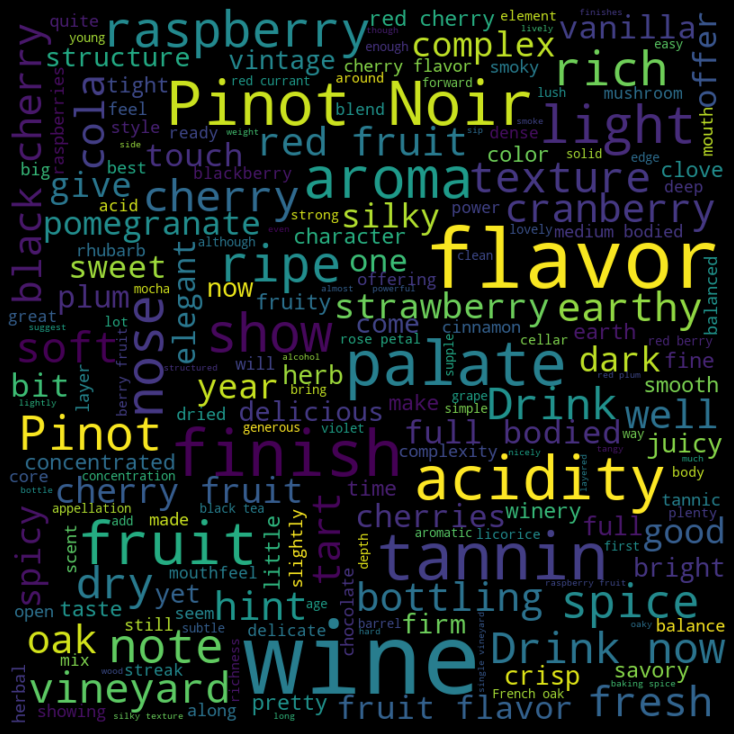

In [ ]:
print('Pinot')
word_cloud_pinot = word_cloud(text_pinot)

Global


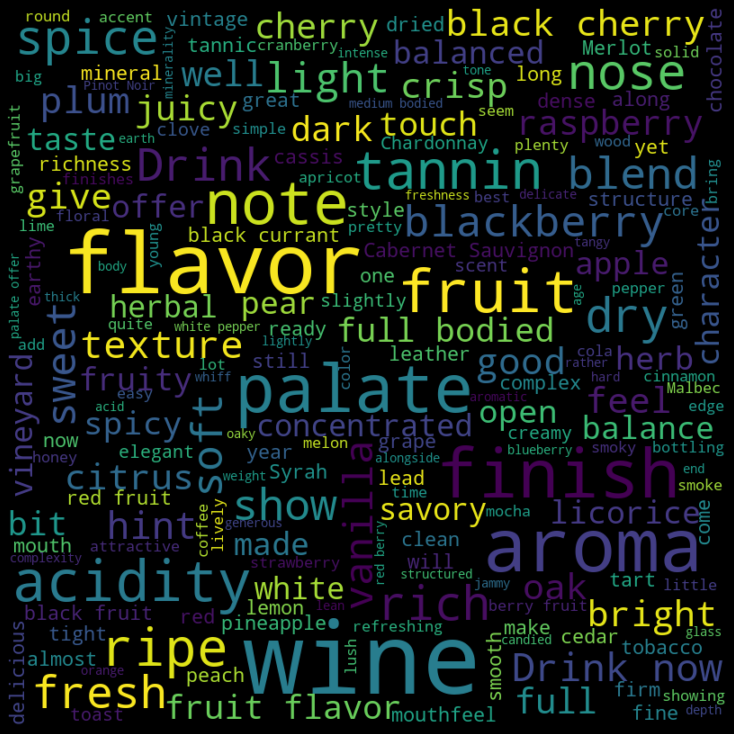

In [ ]:
print('Global')
word_cloud_pinot = word_cloud(text_global)

# Framework: Business Intelligence



## Comparative analysis
The objective here will be to compare each of the client's wines to its competitors on the market. For example, compare the prices for French wines, then more and more precisely, Burgundy wines since our client is in Burgundy, then Burgundy Pinot Noir of the same year. Do not hesitate to be original in the presentation and the dataviz used. Use all the Business Intelligence functionalities in a dashboard to help the client to compare himself (tooltips, filters, etc...).

## Value proposition
With the dashboard you provided, the customer has a clear idea of his competitors. Make him a price proposal according to his positioning (for example: 'if you want to position yourself on the top of the range, the 25% most expensive of your competitors are at this price, we advise you to align yourself with this price').

## Aesthetic quality of the dashboard
Try to keep a critical and visual eye on your dashboard. The form counts as much as the content for the client who is not a data analyst. So think about 'selling' your analysis. For example, with colors inspired by the wine industry, original dataviz, etc...


In [ ]:
domine_variety = df_domaine['variety'].unique()

years_domine = df_domaine['year'].unique()

df_domaine_min_points = df_domaine['points'].min()
df_domaine_max_points = df_domaine['points'].max()

df_domaine_mean_points = (df_domaine_min_points + df_domaine_max_points)/2


print(f"The Domaine des Croix wines rank between {df_domaine_min_points} and {df_domaine_max_points} points, the mean is {df_domaine_mean_points}")

The Domaine des Croix wines rank between 90 and 95 points, the mean is 92.5


In [ ]:
df_domaine_price_analisis = df_domaine.groupby(['year', 'variety'])[['price', 'points']].mean().reset_index()
df_domaine_price_analisis

,year,variety,price,points
0,2014,Chardonnay,NaN,95.00
1,2014,Pinot Noir,NaN,92.00
2,2015,Pinot Noir,NaN,90.00
3,2016,Pinot Noir,NaN,93.00
4,2017,Pinot Noir,NaN,94.00
5,2018,Pinot Noir,NaN,93.25
6,2019,Pinot Noir,NaN,92.00


In [ ]:
df_global_price_analisis = (df_global[(df_global['country'] == 'France')
                      & (df_global['province'] == 'Burgundy')
                      & (df_global['year'].isin(years_domine))
                      & (df_global['variety'].isin(domine_variety))
                      ])

# Choose price range
df_global_price_analisis['decile_rank_by_price'] = pd.qcut(df_global_price_analisis['price'], 10,labels = False)

check_prices = df_global_price_analisis.groupby('decile_rank_by_price')[['price', 'points']].mean().reset_index()

<ipython-input-103-862b6d7c5ada>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
check_prices

,decile_rank_by_price,price,points
0,0,18.303371,84.876404
1,1,24.143750,86.568750
2,2,28.865248,87.624113
3,3,34.360759,88.715190
4,4,40.674699,90.006024
5,5,48.132911,90.392405
6,6,56.433566,90.643357
7,7,67.101266,91.803797
8,8,87.406897,92.365517
9,9,191.802548,93.949045


In [ ]:
# I'll keep wines on the 8th deciles since their poits mean is the closest to the client points mean and not to be a luxury wine
df_global_price_analisis = df_global_price_analisis[df_global_price_analisis['decile_rank_by_price'].between(8, 9, inclusive='left')]
df_global_price_analisis.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,decile_rank_by_price
2227,France,"At this stage, the wine is all dark structure ...",Petite Chapelle Premier Cru,94,82.0,Burgundy,Gevrey-Chambertin,NaN,Roger Voss,@vossroger,Louis Jadot 2015 Petite Chapelle Premier Cru ...,Pinot Noir,Louis Jadot,2015.0,8
3072,France,The aromas of smoky new wood follow through to...,Clos des Mouches Premier Cru,94,91.0,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Joseph Drouhin 2014 Clos des Mouches Premier C...,Pinot Noir,Joseph Drouhin,2014.0,8
3964,France,There is a voluptuous edge to this generous wi...,Les Damodes Premier Cru,90,88.0,Burgundy,Nuits-St.-Georges,NaN,Roger Voss,@vossroger,Louis Latour 2014 Les Damodes Premier Cru (Nu...,Pinot Noir,Louis Latour,2014.0,8
5230,France,"Still young and firm, this wine gives indicati...",NaN,91,77.0,Burgundy,Corton Les Renardes,NaN,Roger Voss,@vossroger,Domaine Maillard 2017 Corton Les Renardes,Pinot Noir,Domaine Maillard,2017.0,8
5753,France,"Three barrels were made of this structured, ta...",Les Beaux Monts Premier Cru,92,100.0,Burgundy,Vosne-Romanée,NaN,Roger Voss,@vossroger,Louis Latour 2018 Les Beaux Monts Premier Cru ...,Pinot Noir,Louis Latour,2018.0,8


In [ ]:
# df_global_price_analisis = df_global_price_analisis.groupby(['year', 'variety'])[['price', 'points']].mean().reset_index()

df_global_price_analisis['price_max'] = df_global_price_analisis['price']

df_global_price_analisis['price_mean'] = df_global_price_analisis['price']

df_global_price_analisis = df_global_price_analisis.groupby(['year', 'variety'])[['price', 'price_max', 'price_mean', 'points']].agg({'price': 'min', 'price_max': 'max', 'price_mean': 'mean', 'points' : 'mean'}).reset_index()

df_global_price_analisis = df_global_price_analisis.rename(columns={"price": "price_min"})

df_global_price_analisis['year'] = df_global_price_analisis['year'].astype('int32')

df_global_price_analisis = df_global_price_analisis[~((df_global_price_analisis['year'] > 2014) & ~(df_global_price_analisis['variety'] == 'Pinot Noir'))]

df_global_price_analisis

,year,variety,price_min,price_max,price_mean,points
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364
3,2015,Pinot Noir,82.0,102.0,92.133333,91.533333
5,2016,Pinot Noir,76.0,104.0,86.428571,91.785714
7,2017,Pinot Noir,76.0,102.0,85.913043,92.521739
9,2018,Pinot Noir,79.0,100.0,87.875000,92.500000
11,2019,Pinot Noir,78.0,92.0,84.000000,93.500000


In [ ]:
df_domaine_price_analisis

,year,variety,price,points
0,2014,Chardonnay,NaN,95.00
1,2014,Pinot Noir,NaN,92.00
2,2015,Pinot Noir,NaN,90.00
3,2016,Pinot Noir,NaN,93.00
4,2017,Pinot Noir,NaN,94.00
5,2018,Pinot Noir,NaN,93.25
6,2019,Pinot Noir,NaN,92.00


In [ ]:
df_price_analisis = df_global_price_analisis.merge(df_domaine_price_analisis, how='inner', on=['year',	'variety'], suffixes=('_global', '_domaine'), copy=True, indicator=False, validate=None)
df_price_analisis =  df_price_analisis.rename(columns={'price':'price_sugested'})
df_price_analisis

,year,variety,price_min,price_max,price_mean,points_global,price_sugested,points_domaine
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667,NaN,95.00
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364,NaN,92.00
2,2015,Pinot Noir,82.0,102.0,92.133333,91.533333,NaN,90.00
3,2016,Pinot Noir,76.0,104.0,86.428571,91.785714,NaN,93.00
4,2017,Pinot Noir,76.0,102.0,85.913043,92.521739,NaN,94.00
5,2018,Pinot Noir,79.0,100.0,87.875000,92.500000,NaN,93.25
6,2019,Pinot Noir,78.0,92.0,84.000000,93.500000,NaN,92.00


In [ ]:
def sugest_price(my_df):
  for i in range(len(my_df)):
    if my_df['points_global'].iloc[i] > my_df['points_domaine'].iloc[i]:
      my_df['price_sugested'].iloc[i] = math.floor(my_df['price_mean'].iloc[i])
    else:
      my_df['price_sugested'].iloc[i] = math.ceil(my_df['price_mean'].iloc[i])
  return my_df

In [ ]:
price_suggestion = sugest_price(df_price_analisis)

In [ ]:
price_suggestion

,year,variety,price_min,price_max,price_mean,points_global,price_sugested,points_domaine
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667,92.0,95.00
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364,92.0,92.00
2,2015,Pinot Noir,82.0,102.0,92.133333,91.533333,92.0,90.00
3,2016,Pinot Noir,76.0,104.0,86.428571,91.785714,87.0,93.00
4,2017,Pinot Noir,76.0,102.0,85.913043,92.521739,86.0,94.00
5,2018,Pinot Noir,79.0,100.0,87.875000,92.500000,88.0,93.25
6,2019,Pinot Noir,78.0,92.0,84.000000,93.500000,84.0,92.00
